In [1]:
import torch
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt
from IPython.display import clear_output
from TD3 import TD3
from time import perf_counter
from tqdm import tqdm
from scipy.signal import savgol_filter

In [2]:
env_string = "MountainCarContinuous-v0"

In [3]:
def run(env, agent, n_episodes=100, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        start = perf_counter()
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            (next_state, reward, done, _trunc, _info) = env.step(action)

            done = _trunc or done
            transition = (state, action, reward, next_state, done)
            agent.store_transition(transition)

            state = next_state

            observations.append(state)
            actions.append(action)
            ep_reward += reward
            
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

In [4]:
def train(env, agent, n_episodes=1000, train_every=1, print_every=10, noise=0.2):
    losses = []
    ep_rewards = []
    step_durations = []
    n_steps = n_episodes // train_every
    ep_per_step = train_every
    try:
        for i in range(n_steps):
            start = perf_counter()
            observations, actions, rewards = run(env, agent, n_episodes=ep_per_step, noise=noise)
            losses.append(np.mean(agent.train(), axis=0))
            ep_rewards.append(rewards)
            step_durations.append(perf_counter() - start)
            if (np.array(rewards) > 50).any():
                print(f"Environment solved in {i*ep_per_step} episodes")
            if i > 0 and i % print_every == 0:
                print(f"Step {i+1}/{n_steps}, mean reward: {np.mean(rewards[-print_every:]):.2f}")
                print(f"Avg step duration: {np.mean(step_durations[-100:]):.3f}s")
    except KeyboardInterrupt:
        print("Interrupted")
    return losses, ep_rewards

In [5]:
env = gym.make(env_string)

In [6]:
agent = TD3(env.observation_space, env.action_space)

In [7]:
# run(env, agent, n_episodes=100, noise=0)

In [8]:
losses, ep_rewards = train(env, agent, n_episodes=30000, print_every=100, noise=0.5)

Environment solved in 2 episodes
Environment solved in 14 episodes
Environment solved in 19 episodes
Environment solved in 84 episodes
Environment solved in 87 episodes
Environment solved in 95 episodes
Step 101/30000, mean reward: -48.67
Avg step duration: 0.307s
Environment solved in 115 episodes
Environment solved in 128 episodes
Environment solved in 192 episodes
Step 201/30000, mean reward: -53.09
Avg step duration: 0.442s
Environment solved in 202 episodes
Environment solved in 212 episodes
Environment solved in 240 episodes
Environment solved in 264 episodes
Environment solved in 271 episodes
Environment solved in 276 episodes
Step 301/30000, mean reward: -730.58
Avg step duration: 0.573s
Environment solved in 306 episodes
Environment solved in 318 episodes
Environment solved in 319 episodes
Environment solved in 323 episodes
Environment solved in 330 episodes
Environment solved in 331 episodes
Environment solved in 337 episodes
Environment solved in 340 episodes
Environment sol

In [9]:
ep_rewards = np.array(ep_rewards)
losses = np.array(losses)

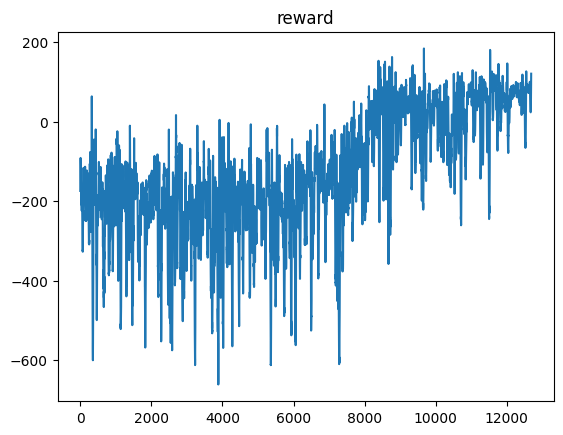

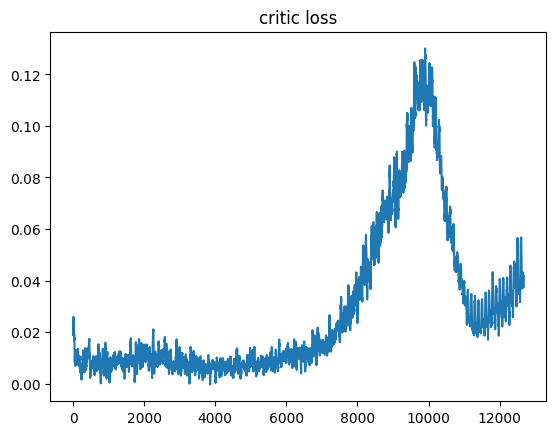

Text(0.5, 1.0, 'actor loss')

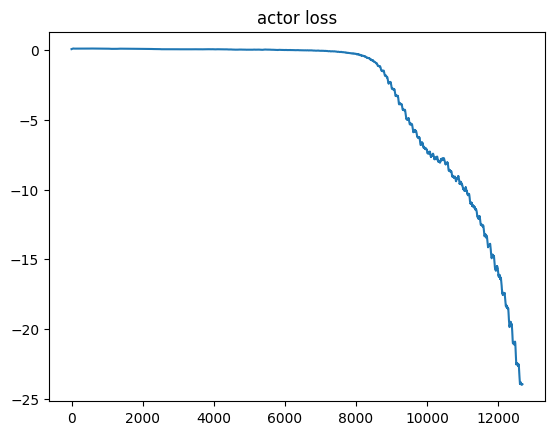

In [10]:
plt.plot(savgol_filter(ep_rewards, 51, 3, axis=0), label='reward')
plt.title('reward')
plt.show()
plt.plot(savgol_filter(losses[:,0], 51, 3, axis=0), label='critic loss')
plt.title('critic loss')
plt.show()
plt.plot(savgol_filter(losses[:,1], 51, 3, axis=0), label='actor loss')
plt.title('actor loss')

In [11]:
def play(env_string, agent, n_episodes=10, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        env = gym.make(env_string, render_mode='human')
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            (next_state, reward, done, _trunc, _info) = env.step(action)

            done = _trunc or done

            state = next_state

            observations.append(state)
            actions.append(action)
            ep_reward += reward
            
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
        env.close()
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

In [12]:
obs, acts, rewards = play("LunarLanderContinuous-v2", agent, n_episodes=1, noise=0)
print(np.sum(rewards))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x8 and 2x256)

: 

In [ ]:
torch.save(agent.state(), 'checkpoint_lunar.pth')

In [ ]:
agent_state = torch.load('checkpoint_lunar.pth')
agent.restore_state(agent_state)